In [3]:
#-*- coding: utf-8 -*-

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")


In [6]:
# seed 값 설정
np.random.seed(42)
tf.random.set_seed(42)

생성자

In [7]:
from re import L
# 생성자 모델 만들기
generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
# 128 노드(임의설정), 7*7 img, input_dim = 100 : 100차원
generator.add(BatchNormalization()) # 배치정규화 (평균 0, 분산 1) 
generator.add(Reshape((7,7, 128)))
generator.add(UpSampling2D()) # img 가로 세로 크기 2배 늘리기
generator.add(Conv2D(64, kernel_size = 5, padding = 'same'))
# kernel_size = 5 (filter 5*5), padding = 'same' : 입출력 크기를 동일하게 (14*14 img)
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2))) # 0보다 작을 경우 : 0.2 곱해서 작은 출력 보기 위해 
generator.add(UpSampling2D()) # 출력 수를 28*28 img로 맞추기 위해서 (mnist 크기니깐)
generator.add(Conv2D(1, kernel_size=3, padding='same', activation = 'tanh'))
# activation = tanh 사용 (-1~1) 상태로 판별자(discriminator)에 넘겨서 크기가 일치한 상태로 만들기 위해

In [8]:
# 판별자 모델 생성

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides =2, input_shape =(28,28,1), padding ='same' ))
# input_shape =(28,28,1) : 28*28 img, 1 channel (흑백)
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding='same'))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten()) # 차원축소 (2차원 >> 1차원)
discriminator.add(Dense(1, activation='sigmoid')) # 이진 분류 ( 참, 거짓)

# 환경설정 (compile)
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer ='adam')
discriminator.trainable = False
# (매우 중요!!!!)
# 판별자 자신이 학습하지 않도록 학습 기능 꺼주어야한다.

In [9]:
# 생성자, 판별자 모델 연결 : gan 

ginput = Input(shape=(100,)) # 무작위로 100개의 벡터 생성
dis_output = discriminator(generator(ginput))

gan=Model(ginput, dis_output)

gan.compile(loss = 'binary_crossentropy',
            optimizer = 'adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         864257    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,077,122
Trainable params: 851,585
Non-trainable params: 225,537
_________________________________________________________________


In [1]:
# 신경망을 실행시키는 함수 정의 

def gan_train(epoch, batch_size, saving_interval):

  # Mnist 데이터 불러오기

  (X_train, _), (_,_) = mnist.load_data()
  # 앞서 불러온 mnist 사용
  # 단, 테스트 과정 없음, 이미지만 사용할 것임 >> X_train 만 불러옴
  
  X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
  # 28*28 img, 색상 1(흑백)

  X_train = (X_train - 127.5) / 127.5
  # pixel 값(흑백) : 0~255 사이 값
  # 255 나눈 것은 0~1 사이
  # 127.5 빼고 나누고 >> -1~1 사이 값

  true =  np.ones((batch_size, 1)) #  모두가 참(1)인 실제 이미지 입력
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    # 실제 데이터를 판별자에 입력하는 부분 
    idx = np.random.randint(0, X_train.shape[0],batch_size)
    # 0~X_train.shape[0] 무작위 추출, batch_size 만큼 반복
    img = X_train[idx] # 선택된 숫자(idx)에 해당되는 이미지 불러옴
    d_loss_real = discriminator.train_on_batch(img, true)

    # 가상 이미지를 판별자에 입력하는 부분
    noise = np.random.normal(0,1, (batch_size, 100)) 
    #normal함수 (평균 0, 분산 1), batch_size만큼 100열 추출
    gan_imgs = generator.predict(noise) # predict() 함수 사용
    d_loss_fake = discriminator.train_on_batch(gan_imgs, fake)

    # 판별자와 생성자의 오차 계산
    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise,true)

    print('epoch:%d'% i, 'd_loss:%.4f'% d_loss, 'g_loss:%.4f'% g_loss)

    # 중간과정 이미지 저장 >> gan_images 폴더에 저장
    if i % saving_interval == 0 :
      noise = np.random.normal(0,1, (25, 100))
      gan_imgs = generator. predict(noise)

      # rescale imgs = 0~1
      gan_imgs = 0.5*gan_imgs +0.5 

      fig,axes = plt.subplots(5,5)

      count = 0 # 초기값 설정

      for j in range(5) : 
        for k in range(5) : 
          axes[j,k].imshow(gan_imgs[count, : ,:,0], cmap='gray')
          axes[j,k].axes('off')
          count += 1
      fig.savefig('gen_images/gan_mnist_&d.png'%i)

epoch:0 d_loss:0.4307 g_loss:0.2653


TypeError: ignored

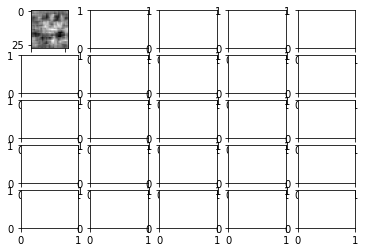

In [11]:
gan_train(4001,32,200)
# 4000번 반복하고, 배치사이즈 = 32, 200번 마다 결과를 저장